<a href="https://colab.research.google.com/github/jeancarson/Block3Epic/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [2]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [3]:
def getTransforms(augmentation=False):
    # mean,std for FashionMNIST (approx)
    mean = (0.2860,)
    std = (0.3530,)

    # TODO: define the transformation for the test set (without any data augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        # TODO: define the transformation for the train set (with data augmentation)
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
        ])

        return train_transform, test_transform

    return test_transform, test_transform

## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [6]:
def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    return train_loader, test_loader
    """

    train_transform, test_transform = getTransforms(augmentation)

    # TODO: download the FashionMNIST dataset
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, train=True, transform=train_transform)
    test_dataset  = torchvision.datasets.FashionMNIST(root='./data', download=True, train=True, transform=test_transform)

    # TODO: create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

Train set size: 60000
Test set size: 60000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [27]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization
        # TODO: Build a sample CNN architecture (refer architecture from week 6 exercise notebook if needed)
        # Note that the FashionMNIST dataset has 10 classes, input size of 28x28 and 1 channel (greyscale)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2) # Remember that a kernel size and stride of 2 each effectively halves the size of the image!

        if self.useRegularization:
            self.dropout =nn.Dropout(dropout_prob)
            pass # remove after completing code above

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128*7*7, 256) # size of image after two pools i.e., 28x28 => ? => ?
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # shape x: (batch,3,32,32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch,64,16,16)

        # Use regularisation layers as you see fit

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        out = self.fc2(x)
        return out

## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [28]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [29]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.300805  [   64/60000]
loss: 0.466313  [ 6464/60000]
loss: 0.418880  [12864/60000]
loss: 0.447199  [19264/60000]
loss: 0.340255  [25664/60000]
loss: 0.363532  [32064/60000]
loss: 0.352193  [38464/60000]
loss: 0.280211  [44864/60000]
loss: 0.241323  [51264/60000]
loss: 0.348364  [57664/60000]


Epochs:  10%|█         | 1/10 [00:45<06:45, 45.06s/it]

Train Error: 
 Accuracy: 91.3%, Avg loss: 0.235956 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.236017 

Epoch 2:

loss: 0.230964  [   64/60000]
loss: 0.278846  [ 6464/60000]
loss: 0.178310  [12864/60000]
loss: 0.262485  [19264/60000]
loss: 0.256140  [25664/60000]
loss: 0.157992  [32064/60000]
loss: 0.247068  [38464/60000]
loss: 0.176620  [44864/60000]
loss: 0.332351  [51264/60000]
loss: 0.142082  [57664/60000]


Epochs:  20%|██        | 2/10 [01:33<06:15, 46.92s/it]

Train Error: 
 Accuracy: 93.2%, Avg loss: 0.193548 

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.193539 

Epoch 3:

loss: 0.104204  [   64/60000]
loss: 0.168596  [ 6464/60000]
loss: 0.119703  [12864/60000]
loss: 0.187169  [19264/60000]
loss: 0.217218  [25664/60000]
loss: 0.129451  [32064/60000]
loss: 0.142836  [38464/60000]
loss: 0.230991  [44864/60000]
loss: 0.287701  [51264/60000]
loss: 0.394086  [57664/60000]


Epochs:  30%|███       | 3/10 [02:23<05:38, 48.31s/it]

Train Error: 
 Accuracy: 95.2%, Avg loss: 0.133502 

Test Error: 
 Accuracy: 95.2%, Avg loss: 0.133442 

Epoch 4:

loss: 0.111364  [   64/60000]
loss: 0.077125  [ 6464/60000]
loss: 0.049079  [12864/60000]
loss: 0.050432  [19264/60000]
loss: 0.267423  [25664/60000]
loss: 0.076434  [32064/60000]
loss: 0.280670  [38464/60000]
loss: 0.146746  [44864/60000]
loss: 0.158145  [51264/60000]
loss: 0.096940  [57664/60000]


Epochs:  40%|████      | 4/10 [03:10<04:46, 47.79s/it]

Train Error: 
 Accuracy: 96.6%, Avg loss: 0.095029 

Test Error: 
 Accuracy: 96.6%, Avg loss: 0.095028 

Epoch 5:

loss: 0.153762  [   64/60000]
loss: 0.191302  [ 6464/60000]
loss: 0.061180  [12864/60000]
loss: 0.159848  [19264/60000]
loss: 0.029332  [25664/60000]
loss: 0.055761  [32064/60000]
loss: 0.156948  [38464/60000]
loss: 0.128196  [44864/60000]
loss: 0.121117  [51264/60000]
loss: 0.124954  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:57<03:58, 47.61s/it]

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.080641 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.080654 

Epoch 6:

loss: 0.061773  [   64/60000]
loss: 0.012052  [ 6464/60000]
loss: 0.142887  [12864/60000]
loss: 0.065120  [19264/60000]
loss: 0.075763  [25664/60000]
loss: 0.183193  [32064/60000]
loss: 0.057811  [38464/60000]
loss: 0.019532  [44864/60000]
loss: 0.088608  [51264/60000]
loss: 0.030866  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:44<03:09, 47.48s/it]

Train Error: 
 Accuracy: 98.3%, Avg loss: 0.050542 

Test Error: 
 Accuracy: 98.3%, Avg loss: 0.050564 

Epoch 7:

loss: 0.069653  [   64/60000]
loss: 0.085198  [ 6464/60000]
loss: 0.011027  [12864/60000]
loss: 0.007132  [19264/60000]
loss: 0.027534  [25664/60000]
loss: 0.031166  [32064/60000]
loss: 0.050701  [38464/60000]
loss: 0.112646  [44864/60000]
loss: 0.110391  [51264/60000]
loss: 0.127384  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:31<02:21, 47.17s/it]

Train Error: 
 Accuracy: 98.6%, Avg loss: 0.038091 

Test Error: 
 Accuracy: 98.6%, Avg loss: 0.038058 

Epoch 8:

loss: 0.021799  [   64/60000]
loss: 0.046085  [ 6464/60000]
loss: 0.005807  [12864/60000]
loss: 0.064957  [19264/60000]
loss: 0.055275  [25664/60000]
loss: 0.015774  [32064/60000]
loss: 0.074702  [38464/60000]
loss: 0.077912  [44864/60000]
loss: 0.150275  [51264/60000]
loss: 0.098192  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:17<01:33, 46.91s/it]

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.044659 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.044782 

Epoch 9:

loss: 0.004092  [   64/60000]
loss: 0.028070  [ 6464/60000]
loss: 0.052498  [12864/60000]
loss: 0.006572  [19264/60000]
loss: 0.040450  [25664/60000]
loss: 0.029964  [32064/60000]
loss: 0.029188  [38464/60000]
loss: 0.047440  [44864/60000]
loss: 0.110199  [51264/60000]
loss: 0.075885  [57664/60000]


Epochs:  90%|█████████ | 9/10 [07:04<00:46, 46.91s/it]

Train Error: 
 Accuracy: 99.2%, Avg loss: 0.023489 

Test Error: 
 Accuracy: 99.2%, Avg loss: 0.023493 

Epoch 10:

loss: 0.011161  [   64/60000]
loss: 0.016913  [ 6464/60000]
loss: 0.006799  [12864/60000]
loss: 0.122602  [19264/60000]
loss: 0.024347  [25664/60000]
loss: 0.029706  [32064/60000]
loss: 0.110405  [38464/60000]
loss: 0.004529  [44864/60000]
loss: 0.026137  [51264/60000]
loss: 0.026901  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:51<00:00, 47.11s/it]

Train Error: 
 Accuracy: 98.9%, Avg loss: 0.031853 

Test Error: 
 Accuracy: 98.9%, Avg loss: 0.031828 

Done training!


Plotting metrics

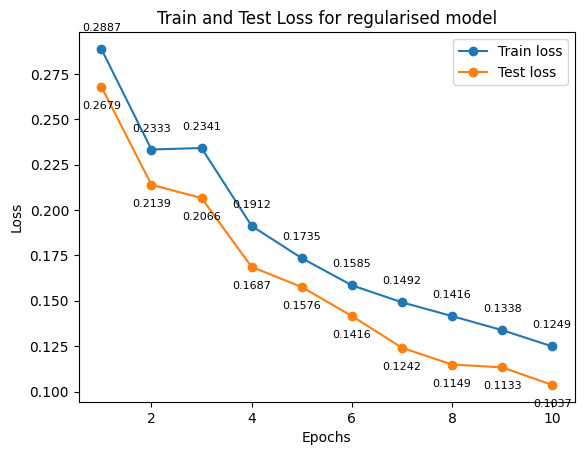

In [38]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

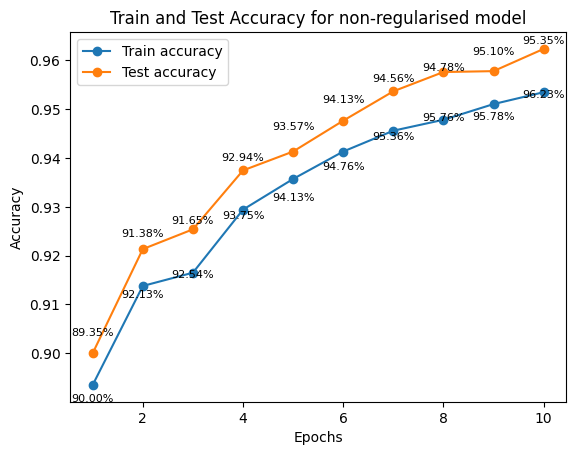

In [37]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [33]:
# Apply only data augmentation
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

model = NetFashion().to(device)

epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.307154  [   64/60000]
loss: 0.508528  [ 6464/60000]
loss: 0.363404  [12864/60000]
loss: 0.479849  [19264/60000]
loss: 0.478443  [25664/60000]
loss: 0.491018  [32064/60000]
loss: 0.344584  [38464/60000]
loss: 0.332264  [44864/60000]
loss: 0.371978  [51264/60000]
loss: 0.388725  [57664/60000]


Epochs:  10%|█         | 1/10 [00:58<08:45, 58.41s/it]

Train Error: 
 Accuracy: 89.4%, Avg loss: 0.288697 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.267917 

Epoch 2:

loss: 0.415905  [   64/60000]
loss: 0.171339  [ 6464/60000]
loss: 0.331656  [12864/60000]
loss: 0.197288  [19264/60000]
loss: 0.394861  [25664/60000]
loss: 0.320279  [32064/60000]
loss: 0.196028  [38464/60000]
loss: 0.299049  [44864/60000]
loss: 0.335492  [51264/60000]
loss: 0.252380  [57664/60000]


Epochs:  20%|██        | 2/10 [01:58<07:53, 59.16s/it]

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.233308 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.213897 

Epoch 3:

loss: 0.249932  [   64/60000]
loss: 0.168478  [ 6464/60000]
loss: 0.279651  [12864/60000]
loss: 0.236440  [19264/60000]
loss: 0.290082  [25664/60000]
loss: 0.316035  [32064/60000]
loss: 0.344939  [38464/60000]
loss: 0.197306  [44864/60000]
loss: 0.306208  [51264/60000]
loss: 0.279628  [57664/60000]


Epochs:  30%|███       | 3/10 [02:57<06:54, 59.28s/it]

Train Error: 
 Accuracy: 91.6%, Avg loss: 0.234127 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.206578 

Epoch 4:

loss: 0.255732  [   64/60000]
loss: 0.116132  [ 6464/60000]
loss: 0.116023  [12864/60000]
loss: 0.330078  [19264/60000]
loss: 0.179121  [25664/60000]
loss: 0.099742  [32064/60000]
loss: 0.195115  [38464/60000]
loss: 0.409114  [44864/60000]
loss: 0.210488  [51264/60000]
loss: 0.097933  [57664/60000]


Epochs:  40%|████      | 4/10 [03:54<05:51, 58.53s/it]

Train Error: 
 Accuracy: 92.9%, Avg loss: 0.191226 

Test Error: 
 Accuracy: 93.7%, Avg loss: 0.168677 

Epoch 5:

loss: 0.350749  [   64/60000]
loss: 0.153282  [ 6464/60000]
loss: 0.177655  [12864/60000]
loss: 0.220808  [19264/60000]
loss: 0.266358  [25664/60000]
loss: 0.302095  [32064/60000]
loss: 0.160853  [38464/60000]
loss: 0.171343  [44864/60000]
loss: 0.272227  [51264/60000]
loss: 0.211486  [57664/60000]


Epochs:  50%|█████     | 5/10 [04:59<05:02, 60.57s/it]

Train Error: 
 Accuracy: 93.6%, Avg loss: 0.173475 

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.157586 

Epoch 6:

loss: 0.216223  [   64/60000]
loss: 0.175861  [ 6464/60000]
loss: 0.120172  [12864/60000]
loss: 0.448773  [19264/60000]
loss: 0.131064  [25664/60000]
loss: 0.162739  [32064/60000]
loss: 0.162965  [38464/60000]
loss: 0.218374  [44864/60000]
loss: 0.201319  [51264/60000]
loss: 0.369876  [57664/60000]


Epochs:  60%|██████    | 6/10 [05:57<03:59, 59.95s/it]

Train Error: 
 Accuracy: 94.1%, Avg loss: 0.158523 

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.141622 

Epoch 7:

loss: 0.056591  [   64/60000]
loss: 0.224315  [ 6464/60000]
loss: 0.133612  [12864/60000]
loss: 0.401184  [19264/60000]
loss: 0.112093  [25664/60000]
loss: 0.131676  [32064/60000]
loss: 0.103362  [38464/60000]
loss: 0.183737  [44864/60000]
loss: 0.110967  [51264/60000]
loss: 0.155883  [57664/60000]


Epochs:  70%|███████   | 7/10 [06:55<02:57, 59.05s/it]

Train Error: 
 Accuracy: 94.6%, Avg loss: 0.149170 

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.124157 

Epoch 8:

loss: 0.070291  [   64/60000]
loss: 0.080055  [ 6464/60000]
loss: 0.209216  [12864/60000]
loss: 0.099883  [19264/60000]
loss: 0.106846  [25664/60000]
loss: 0.236196  [32064/60000]
loss: 0.137191  [38464/60000]
loss: 0.154555  [44864/60000]
loss: 0.164538  [51264/60000]
loss: 0.082881  [57664/60000]


Epochs:  80%|████████  | 8/10 [07:58<02:00, 60.46s/it]

Train Error: 
 Accuracy: 94.8%, Avg loss: 0.141565 

Test Error: 
 Accuracy: 95.8%, Avg loss: 0.114892 

Epoch 9:

loss: 0.066664  [   64/60000]
loss: 0.305593  [ 6464/60000]
loss: 0.108273  [12864/60000]
loss: 0.135554  [19264/60000]
loss: 0.113777  [25664/60000]
loss: 0.170373  [32064/60000]
loss: 0.146489  [38464/60000]
loss: 0.127783  [44864/60000]
loss: 0.211992  [51264/60000]
loss: 0.195622  [57664/60000]


Epochs:  90%|█████████ | 9/10 [08:55<00:59, 59.43s/it]

Train Error: 
 Accuracy: 95.1%, Avg loss: 0.133824 

Test Error: 
 Accuracy: 95.8%, Avg loss: 0.113338 

Epoch 10:

loss: 0.094784  [   64/60000]
loss: 0.151856  [ 6464/60000]
loss: 0.057368  [12864/60000]
loss: 0.034794  [19264/60000]
loss: 0.068187  [25664/60000]
loss: 0.073867  [32064/60000]
loss: 0.152717  [38464/60000]
loss: 0.139587  [44864/60000]
loss: 0.140186  [51264/60000]
loss: 0.308834  [57664/60000]


Epochs: 100%|██████████| 10/10 [09:53<00:00, 59.40s/it]

Train Error: 
 Accuracy: 95.3%, Avg loss: 0.124882 

Test Error: 
 Accuracy: 96.2%, Avg loss: 0.103664 

Done training!


Plotting metrics

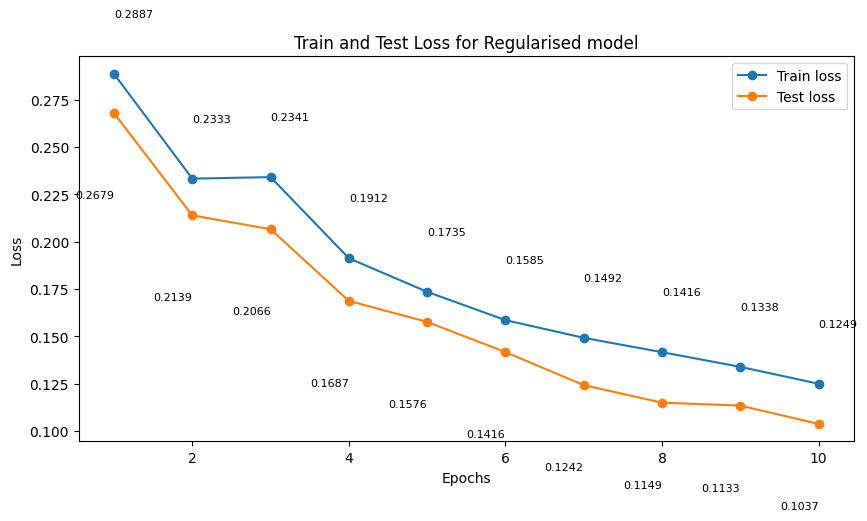

In [34]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

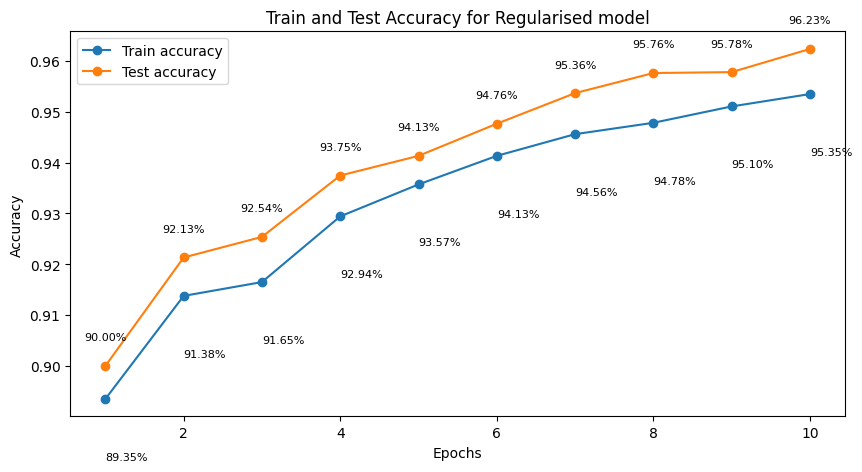

In [35]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [39]:
# Apply only regularisation on the cnn model
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion(useRegularization=True).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.305989  [   64/60000]
loss: 0.740828  [ 6464/60000]
loss: 0.509437  [12864/60000]
loss: 0.495521  [19264/60000]
loss: 0.305761  [25664/60000]
loss: 0.379941  [32064/60000]
loss: 0.316024  [38464/60000]
loss: 0.327189  [44864/60000]
loss: 0.263841  [51264/60000]
loss: 0.264736  [57664/60000]


Epochs:  10%|█         | 1/10 [00:46<06:56, 46.33s/it]

Train Error: 
 Accuracy: 91.5%, Avg loss: 0.234208 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.234236 

Epoch 2:

loss: 0.219939  [   64/60000]
loss: 0.255105  [ 6464/60000]
loss: 0.321329  [12864/60000]
loss: 0.160187  [19264/60000]
loss: 0.274347  [25664/60000]
loss: 0.252903  [32064/60000]
loss: 0.194331  [38464/60000]
loss: 0.101679  [44864/60000]
loss: 0.238929  [51264/60000]
loss: 0.283976  [57664/60000]


Epochs:  20%|██        | 2/10 [01:30<05:58, 44.80s/it]

Train Error: 
 Accuracy: 93.5%, Avg loss: 0.178392 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.178378 

Epoch 3:

loss: 0.104848  [   64/60000]
loss: 0.199230  [ 6464/60000]
loss: 0.207225  [12864/60000]
loss: 0.205541  [19264/60000]
loss: 0.180722  [25664/60000]
loss: 0.160252  [32064/60000]
loss: 0.160706  [38464/60000]
loss: 0.256099  [44864/60000]
loss: 0.107674  [51264/60000]
loss: 0.092258  [57664/60000]


Epochs:  30%|███       | 3/10 [02:18<05:24, 46.41s/it]

Train Error: 
 Accuracy: 95.3%, Avg loss: 0.146141 

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.146198 

Epoch 4:

loss: 0.171041  [   64/60000]
loss: 0.062725  [ 6464/60000]
loss: 0.222386  [12864/60000]
loss: 0.231370  [19264/60000]
loss: 0.076938  [25664/60000]
loss: 0.137019  [32064/60000]
loss: 0.175400  [38464/60000]
loss: 0.287356  [44864/60000]
loss: 0.089510  [51264/60000]
loss: 0.207937  [57664/60000]


Epochs:  40%|████      | 4/10 [03:02<04:33, 45.52s/it]

Train Error: 
 Accuracy: 95.5%, Avg loss: 0.115887 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.115931 

Epoch 5:

loss: 0.108631  [   64/60000]
loss: 0.069419  [ 6464/60000]
loss: 0.121214  [12864/60000]
loss: 0.095053  [19264/60000]
loss: 0.044201  [25664/60000]
loss: 0.213143  [32064/60000]
loss: 0.130870  [38464/60000]
loss: 0.109134  [44864/60000]
loss: 0.080275  [51264/60000]
loss: 0.118811  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:46<03:45, 45.01s/it]

Train Error: 
 Accuracy: 97.2%, Avg loss: 0.078342 

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.078369 

Epoch 6:

loss: 0.054082  [   64/60000]
loss: 0.040459  [ 6464/60000]
loss: 0.206390  [12864/60000]
loss: 0.048084  [19264/60000]
loss: 0.045472  [25664/60000]
loss: 0.101365  [32064/60000]
loss: 0.099714  [38464/60000]
loss: 0.072623  [44864/60000]
loss: 0.055667  [51264/60000]
loss: 0.033432  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:30<02:58, 44.50s/it]

Train Error: 
 Accuracy: 97.9%, Avg loss: 0.063331 

Test Error: 
 Accuracy: 97.9%, Avg loss: 0.063352 

Epoch 7:

loss: 0.069839  [   64/60000]
loss: 0.013843  [ 6464/60000]
loss: 0.011631  [12864/60000]
loss: 0.124113  [19264/60000]
loss: 0.052753  [25664/60000]
loss: 0.211455  [32064/60000]
loss: 0.080397  [38464/60000]
loss: 0.090810  [44864/60000]
loss: 0.030140  [51264/60000]
loss: 0.082146  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:14<02:13, 44.46s/it]

Train Error: 
 Accuracy: 98.6%, Avg loss: 0.042013 

Test Error: 
 Accuracy: 98.6%, Avg loss: 0.041982 

Epoch 8:

loss: 0.072199  [   64/60000]
loss: 0.038925  [ 6464/60000]
loss: 0.117925  [12864/60000]
loss: 0.038996  [19264/60000]
loss: 0.117290  [25664/60000]
loss: 0.084721  [32064/60000]
loss: 0.036962  [38464/60000]
loss: 0.053683  [44864/60000]
loss: 0.017059  [51264/60000]
loss: 0.044586  [57664/60000]


Epochs:  80%|████████  | 8/10 [05:58<01:28, 44.17s/it]

Train Error: 
 Accuracy: 99.0%, Avg loss: 0.029563 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.029522 

Epoch 9:

loss: 0.050868  [   64/60000]
loss: 0.010874  [ 6464/60000]
loss: 0.007929  [12864/60000]
loss: 0.063747  [19264/60000]
loss: 0.044111  [25664/60000]
loss: 0.051211  [32064/60000]
loss: 0.039068  [38464/60000]
loss: 0.070949  [44864/60000]
loss: 0.081231  [51264/60000]
loss: 0.039400  [57664/60000]


Epochs:  90%|█████████ | 9/10 [06:42<00:44, 44.28s/it]

Train Error: 
 Accuracy: 98.9%, Avg loss: 0.029175 

Test Error: 
 Accuracy: 98.9%, Avg loss: 0.029194 

Epoch 10:

loss: 0.009926  [   64/60000]
loss: 0.004872  [ 6464/60000]
loss: 0.016706  [12864/60000]
loss: 0.057393  [19264/60000]
loss: 0.112294  [25664/60000]
loss: 0.000865  [32064/60000]
loss: 0.013992  [38464/60000]
loss: 0.005392  [44864/60000]
loss: 0.054620  [51264/60000]
loss: 0.014105  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:26<00:00, 44.64s/it]

Train Error: 
 Accuracy: 99.1%, Avg loss: 0.024937 

Test Error: 
 Accuracy: 99.1%, Avg loss: 0.024953 

Done training!


Plotting metrics

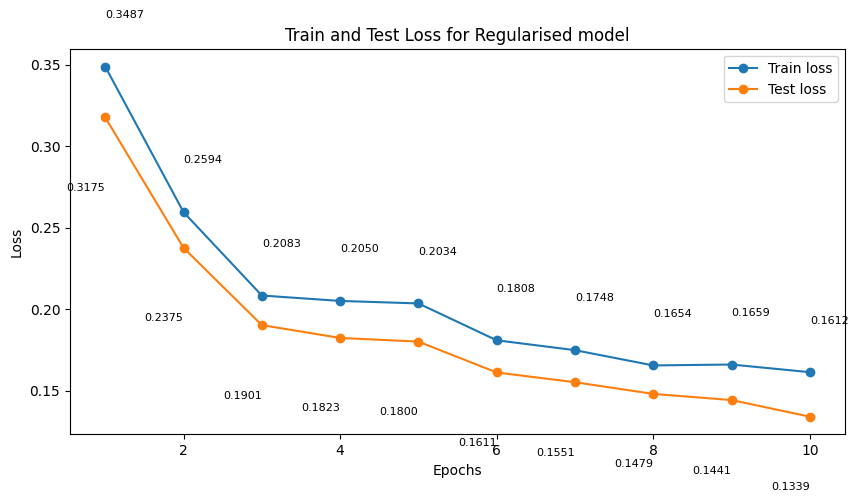

In [56]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

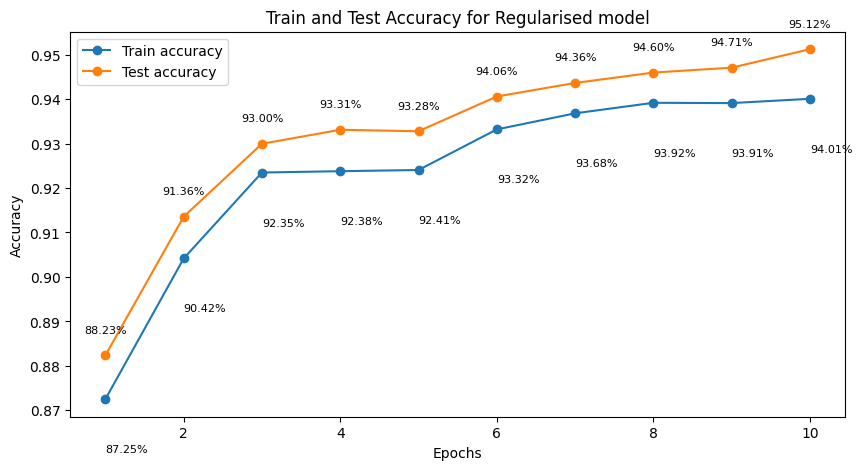

In [57]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [44]:
# Apply only weight decay technique
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion().to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.304839  [   64/60000]
loss: 0.594978  [ 6464/60000]
loss: 0.363705  [12864/60000]
loss: 0.458939  [19264/60000]
loss: 0.252130  [25664/60000]
loss: 0.208860  [32064/60000]
loss: 0.321402  [38464/60000]
loss: 0.120188  [44864/60000]
loss: 0.298482  [51264/60000]
loss: 0.195190  [57664/60000]


Epochs:  10%|█         | 1/10 [00:44<06:44, 44.93s/it]

Train Error: 
 Accuracy: 90.2%, Avg loss: 0.263592 

Test Error: 
 Accuracy: 90.2%, Avg loss: 0.263638 

Epoch 2:

loss: 0.218525  [   64/60000]
loss: 0.236845  [ 6464/60000]
loss: 0.170145  [12864/60000]
loss: 0.349921  [19264/60000]
loss: 0.162898  [25664/60000]
loss: 0.117818  [32064/60000]
loss: 0.370854  [38464/60000]
loss: 0.331670  [44864/60000]
loss: 0.223802  [51264/60000]
loss: 0.173940  [57664/60000]


Epochs:  20%|██        | 2/10 [01:29<05:56, 44.56s/it]

Train Error: 
 Accuracy: 92.9%, Avg loss: 0.194803 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.194799 

Epoch 3:

loss: 0.082570  [   64/60000]
loss: 0.260082  [ 6464/60000]
loss: 0.185063  [12864/60000]
loss: 0.056031  [19264/60000]
loss: 0.258864  [25664/60000]
loss: 0.218997  [32064/60000]
loss: 0.192056  [38464/60000]
loss: 0.138295  [44864/60000]
loss: 0.105175  [51264/60000]
loss: 0.141923  [57664/60000]


Epochs:  30%|███       | 3/10 [02:14<05:13, 44.77s/it]

Train Error: 
 Accuracy: 94.6%, Avg loss: 0.157370 

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.157352 

Epoch 4:

loss: 0.242850  [   64/60000]
loss: 0.092266  [ 6464/60000]
loss: 0.118865  [12864/60000]
loss: 0.155213  [19264/60000]
loss: 0.149316  [25664/60000]
loss: 0.141833  [32064/60000]
loss: 0.181520  [38464/60000]
loss: 0.151179  [44864/60000]
loss: 0.402211  [51264/60000]
loss: 0.098562  [57664/60000]


Epochs:  40%|████      | 4/10 [02:58<04:27, 44.59s/it]

Train Error: 
 Accuracy: 95.0%, Avg loss: 0.137256 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.137167 

Epoch 5:

loss: 0.077398  [   64/60000]
loss: 0.059515  [ 6464/60000]
loss: 0.196435  [12864/60000]
loss: 0.114172  [19264/60000]
loss: 0.334138  [25664/60000]
loss: 0.229654  [32064/60000]
loss: 0.184828  [38464/60000]
loss: 0.063238  [44864/60000]
loss: 0.132087  [51264/60000]
loss: 0.255073  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:43<03:43, 44.61s/it]

Train Error: 
 Accuracy: 96.2%, Avg loss: 0.108242 

Test Error: 
 Accuracy: 96.2%, Avg loss: 0.108227 

Epoch 6:

loss: 0.168439  [   64/60000]
loss: 0.096371  [ 6464/60000]
loss: 0.041677  [12864/60000]
loss: 0.120849  [19264/60000]
loss: 0.111648  [25664/60000]
loss: 0.069905  [32064/60000]
loss: 0.110125  [38464/60000]
loss: 0.187883  [44864/60000]
loss: 0.199738  [51264/60000]
loss: 0.171689  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:26<02:57, 44.27s/it]

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.080328 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.080323 

Epoch 7:

loss: 0.070877  [   64/60000]
loss: 0.072818  [ 6464/60000]
loss: 0.025369  [12864/60000]
loss: 0.147554  [19264/60000]
loss: 0.133842  [25664/60000]
loss: 0.145196  [32064/60000]
loss: 0.140527  [38464/60000]
loss: 0.098568  [44864/60000]
loss: 0.065856  [51264/60000]
loss: 0.162665  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:10<02:12, 44.14s/it]

Train Error: 
 Accuracy: 97.6%, Avg loss: 0.072076 

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.072101 

Epoch 8:

loss: 0.043433  [   64/60000]
loss: 0.081325  [ 6464/60000]
loss: 0.121130  [12864/60000]
loss: 0.046291  [19264/60000]
loss: 0.152159  [25664/60000]
loss: 0.086948  [32064/60000]
loss: 0.133803  [38464/60000]
loss: 0.046996  [44864/60000]
loss: 0.114089  [51264/60000]
loss: 0.024943  [57664/60000]


Epochs:  80%|████████  | 8/10 [05:56<01:29, 44.59s/it]

Train Error: 
 Accuracy: 98.1%, Avg loss: 0.060432 

Test Error: 
 Accuracy: 98.1%, Avg loss: 0.060429 

Epoch 9:

loss: 0.098469  [   64/60000]
loss: 0.074077  [ 6464/60000]
loss: 0.138485  [12864/60000]
loss: 0.134491  [19264/60000]
loss: 0.085594  [25664/60000]
loss: 0.045658  [32064/60000]
loss: 0.172446  [38464/60000]
loss: 0.072992  [44864/60000]
loss: 0.032728  [51264/60000]
loss: 0.063742  [57664/60000]


Epochs:  90%|█████████ | 9/10 [06:42<00:44, 44.98s/it]

Train Error: 
 Accuracy: 97.7%, Avg loss: 0.064356 

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.064333 

Epoch 10:

loss: 0.063119  [   64/60000]
loss: 0.040501  [ 6464/60000]
loss: 0.025977  [12864/60000]
loss: 0.096109  [19264/60000]
loss: 0.116053  [25664/60000]
loss: 0.079112  [32064/60000]
loss: 0.152997  [38464/60000]
loss: 0.028704  [44864/60000]
loss: 0.074635  [51264/60000]
loss: 0.053544  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:26<00:00, 44.60s/it]

Train Error: 
 Accuracy: 98.4%, Avg loss: 0.045579 

Test Error: 
 Accuracy: 98.4%, Avg loss: 0.045554 

Done training!


Plotting metrics

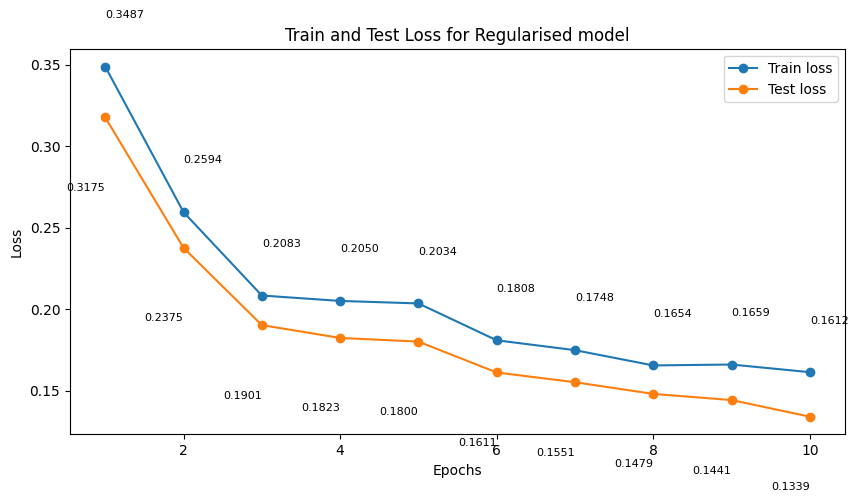

In [54]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

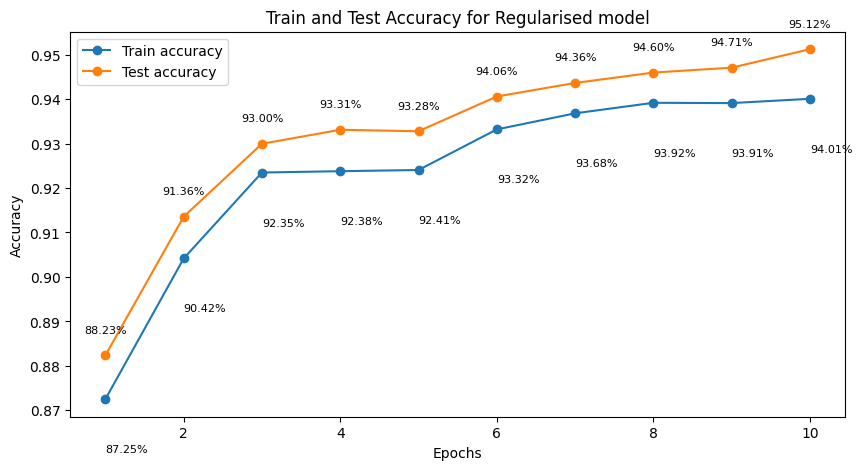

In [55]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [51]:
# Apply all regularisation techniques
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

model = NetFashion(useRegularization=True).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
# optimiser =
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.312448  [   64/60000]
loss: 0.425953  [ 6464/60000]
loss: 0.363171  [12864/60000]
loss: 0.450444  [19264/60000]
loss: 0.302478  [25664/60000]
loss: 0.326521  [32064/60000]
loss: 0.492474  [38464/60000]
loss: 0.412409  [44864/60000]
loss: 0.222603  [51264/60000]
loss: 0.168065  [57664/60000]


Epochs:  10%|█         | 1/10 [00:56<08:28, 56.48s/it]

Train Error: 
 Accuracy: 87.2%, Avg loss: 0.348707 

Test Error: 
 Accuracy: 88.2%, Avg loss: 0.317545 

Epoch 2:

loss: 0.382516  [   64/60000]
loss: 0.283862  [ 6464/60000]
loss: 0.246171  [12864/60000]
loss: 0.290152  [19264/60000]
loss: 0.366770  [25664/60000]
loss: 0.149127  [32064/60000]
loss: 0.262955  [38464/60000]
loss: 0.175924  [44864/60000]
loss: 0.266517  [51264/60000]
loss: 0.303017  [57664/60000]


Epochs:  20%|██        | 2/10 [01:52<07:28, 56.04s/it]

Train Error: 
 Accuracy: 90.4%, Avg loss: 0.259431 

Test Error: 
 Accuracy: 91.4%, Avg loss: 0.237524 

Epoch 3:

loss: 0.419108  [   64/60000]
loss: 0.236421  [ 6464/60000]
loss: 0.148115  [12864/60000]
loss: 0.294731  [19264/60000]
loss: 0.279702  [25664/60000]
loss: 0.248622  [32064/60000]
loss: 0.231338  [38464/60000]
loss: 0.191219  [44864/60000]
loss: 0.225595  [51264/60000]
loss: 0.292919  [57664/60000]


Epochs:  30%|███       | 3/10 [02:49<06:35, 56.49s/it]

Train Error: 
 Accuracy: 92.3%, Avg loss: 0.208278 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.190128 

Epoch 4:

loss: 0.152290  [   64/60000]
loss: 0.244856  [ 6464/60000]
loss: 0.116193  [12864/60000]
loss: 0.224703  [19264/60000]
loss: 0.199709  [25664/60000]
loss: 0.219334  [32064/60000]
loss: 0.217403  [38464/60000]
loss: 0.182768  [44864/60000]
loss: 0.188351  [51264/60000]
loss: 0.398110  [57664/60000]


Epochs:  40%|████      | 4/10 [03:46<05:40, 56.73s/it]

Train Error: 
 Accuracy: 92.4%, Avg loss: 0.204960 

Test Error: 
 Accuracy: 93.3%, Avg loss: 0.182256 

Epoch 5:

loss: 0.196016  [   64/60000]
loss: 0.099075  [ 6464/60000]
loss: 0.221115  [12864/60000]
loss: 0.248973  [19264/60000]
loss: 0.134859  [25664/60000]
loss: 0.254520  [32064/60000]
loss: 0.251931  [38464/60000]
loss: 0.221003  [44864/60000]
loss: 0.169475  [51264/60000]
loss: 0.203362  [57664/60000]


Epochs:  50%|█████     | 5/10 [04:44<04:45, 57.15s/it]

Train Error: 
 Accuracy: 92.4%, Avg loss: 0.203427 

Test Error: 
 Accuracy: 93.3%, Avg loss: 0.180007 

Epoch 6:

loss: 0.204190  [   64/60000]
loss: 0.192122  [ 6464/60000]
loss: 0.166413  [12864/60000]
loss: 0.182783  [19264/60000]
loss: 0.154060  [25664/60000]
loss: 0.147707  [32064/60000]
loss: 0.208729  [38464/60000]
loss: 0.212296  [44864/60000]
loss: 0.204357  [51264/60000]
loss: 0.205316  [57664/60000]


Epochs:  60%|██████    | 6/10 [05:42<03:49, 57.50s/it]

Train Error: 
 Accuracy: 93.3%, Avg loss: 0.180809 

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.161059 

Epoch 7:

loss: 0.155407  [   64/60000]
loss: 0.219501  [ 6464/60000]
loss: 0.275331  [12864/60000]
loss: 0.175020  [19264/60000]
loss: 0.136645  [25664/60000]
loss: 0.148943  [32064/60000]
loss: 0.426993  [38464/60000]
loss: 0.087135  [44864/60000]
loss: 0.217669  [51264/60000]
loss: 0.240694  [57664/60000]


Epochs:  70%|███████   | 7/10 [06:40<02:53, 57.73s/it]

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.174752 

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.155087 

Epoch 8:

loss: 0.365090  [   64/60000]
loss: 0.233299  [ 6464/60000]
loss: 0.112304  [12864/60000]
loss: 0.116868  [19264/60000]
loss: 0.240823  [25664/60000]
loss: 0.245585  [32064/60000]
loss: 0.304970  [38464/60000]
loss: 0.224647  [44864/60000]
loss: 0.413161  [51264/60000]
loss: 0.244733  [57664/60000]


Epochs:  80%|████████  | 8/10 [07:37<01:54, 57.42s/it]

Train Error: 
 Accuracy: 93.9%, Avg loss: 0.165385 

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.147915 

Epoch 9:

loss: 0.076992  [   64/60000]
loss: 0.417501  [ 6464/60000]
loss: 0.309618  [12864/60000]
loss: 0.157156  [19264/60000]
loss: 0.174244  [25664/60000]
loss: 0.172212  [32064/60000]
loss: 0.135810  [38464/60000]
loss: 0.349323  [44864/60000]
loss: 0.076281  [51264/60000]
loss: 0.292868  [57664/60000]


Epochs:  90%|█████████ | 9/10 [08:35<00:57, 57.67s/it]

Train Error: 
 Accuracy: 93.9%, Avg loss: 0.165934 

Test Error: 
 Accuracy: 94.7%, Avg loss: 0.144133 

Epoch 10:

loss: 0.089027  [   64/60000]
loss: 0.142775  [ 6464/60000]
loss: 0.165143  [12864/60000]
loss: 0.196160  [19264/60000]
loss: 0.200917  [25664/60000]
loss: 0.140813  [32064/60000]
loss: 0.200378  [38464/60000]
loss: 0.121954  [44864/60000]
loss: 0.245323  [51264/60000]
loss: 0.246784  [57664/60000]


Epochs: 100%|██████████| 10/10 [09:32<00:00, 57.29s/it]

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.161245 

Test Error: 
 Accuracy: 95.1%, Avg loss: 0.133947 

Done training!


Plotting metrics

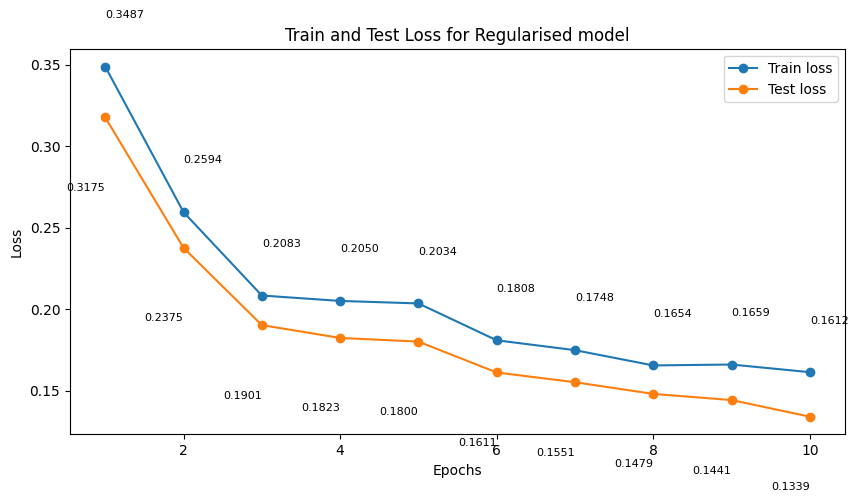

In [52]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

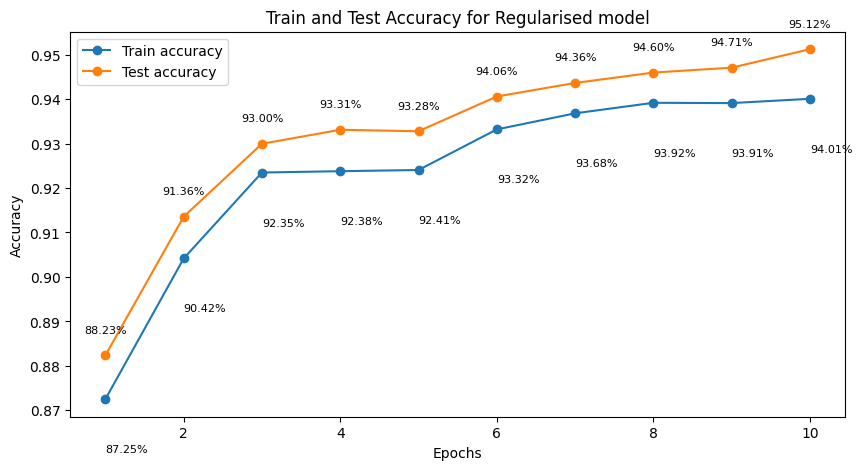

In [53]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

<font color='red'>When we don't use any of these techniques the model overfits to the data and we can see that the accuracy increases not only taper off with more epochs but that when training, accuracy actually decreases with more epochs.
- Ddata augmentation reduced overfitting compared to the baseline and produced a better test accuracy.
- Regularization also improved the model's generalization capabilities.
- Adding weight decay to the optimizer further helped in minimizing overfitting
- the best result was when using all three together </font>

